# Proyecto procesamiento de imagenes

In [1]:
import cv2
from pyzbar.pyzbar import decode
import matplotlib.pyplot as plt

In [2]:
# Decode QR codes
def decode_qr(qr_image):
  decoded_objects = decode(qr_image)
  if not decoded_objects:
      return False, ""
  return True, decoded_objects[0].data.decode("utf-8")


def get_txt_content(file_name):
  with open(file_name, 'r') as file:
    content = file.read()
  return content

def checkQr(image, txt_file_path):
  content = get_txt_content(txt_file_path)

  ok, decoded = decode_qr(image)
  if ok:
    return decoded == content
  return False

In [3]:
class Pipeline:
    def __init__(self, steps):
        self.steps = steps

    def run(self, data):
        for step in self.steps:
            data = step(data)
        return data


In [4]:

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [5]:

def threshold(threshold_value=128):
    def inner(image, threshold_value=threshold_value):
        _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
        return thresholded_image
    return inner

In [18]:
def opening(kernel):
    def inner(image, kernel=kernel):
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return inner

def squared_opening(kernel_size=5):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    return opening(kernel)

In [7]:
def closing(kernel):
    def inner(image, kernel=kernel):
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return inner

In [10]:
def show_image(label, image):
  ## Create a plot
  plt.imshow(image, cmap='gray')
  plt.title(label)
  plt.axis('off')
  plt.show()

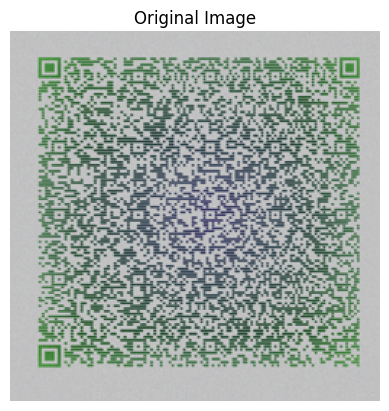

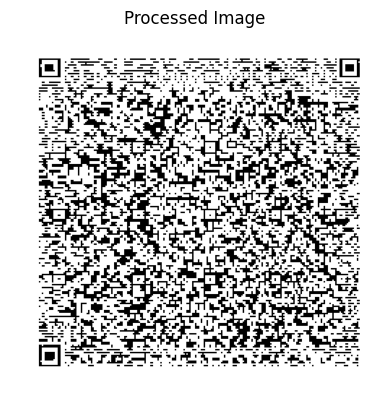

Original QR code validity: False
Processed QR code validity: False


In [20]:
''' 
This script test the transformation pipeline for a single image.
'''
image_name = "000001"

image = cv2.imread(f"png/{image_name}.png")
if image is None:
    raise FileNotFoundError("Image not found. Please check the file path.")

## Show original image
show_image("Original Image", image)

## Create a pipeline with the steps
pipeline = Pipeline([
    grayscale,
    threshold(128),
    squared_opening(kernel_size=1),
])

# Run the pipeline
processed_image = pipeline.run(image)

# Show processed image
show_image("Processed Image", processed_image)

## Check if the QR code is valid
txt_file_path = f"txt/{image_name}.txt"
original_validity = checkQr(image, txt_file_path)
processed_validity = checkQr(processed_image, txt_file_path)

print(f"Original QR code validity: {original_validity}")
print(f"Processed QR code validity: {processed_validity}")


In [ ]:
'''
This script processes images in a directory, aplying a series of transformations defined in a pipeline.
'''

# Get file names in /png
import os

def checAll():
  files = os.listdir("png")
  files = [file.split(".")[0] for file in files]

  # Set pipeline
  pipeline = Pipeline([
      # threshold(128),
      # grayscale
  ])

  # Initialize counters to compare original vs transformed 
  enhanced_count = 0
  worsened_count = 0
  same_ok_count = 0
  same_false_count = 0


  for file in files:
    # Read image
    img = cv2.imread("png/" + file + ".png")
    if img is None:
      print(f"Image {file}.png not found.")
      continue

    # Read text file
    file_name = "txt/" + file + ".txt"

    # Apply pipeline
    img_transformed = pipeline.run(img)

    # Show result of pipeline 
    ok = checkQr(img, file_name)
    transformed_ok  = checkQr(img_transformed, file_name)

    if ok:
      if transformed_ok: same_ok_count += 1
      else: worsened_count += 1
    else:
      if transformed_ok: enhanced_count += 1
      else: same_false_count += 1
    

  # Print summary
  print(f"Total images: {len(files)}")
  print(f"enhanced_count: {enhanced_count}")
  print(f"worsened_count: {worsened_count}")
  print(f"same_ok_count: {same_ok_count}")
  print(f"same_false_count: {same_false_count}")


## Run the check for all images
# checAll()
